In [117]:
import pandas as pd
import numpy as np
import numpy as np
from numpy import genfromtxt
import time
from scipy.fft import fft, ifft

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Reshape
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D,Conv1DTranspose
from keras.layers.convolutional import MaxPooling1D
from keras.layers import LSTM, Bidirectional,ConvLSTM1D
from keras.layers import TimeDistributed,GaussianNoise
from keras.layers import RepeatVector
from keras.layers import Input,LeakyReLU,LayerNormalization
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split


BATCH_SIZE = 64*4
EPOCHS = 300
A=10
in_size=100
scaler=800

df=pd.read_csv('pricedata.csv')
df2=df

opener_ref=df['Open'].to_numpy()/scaler
closer_ref=df['Close'].to_numpy()/scaler

con1_1=df['Open'].to_numpy()
con2_1=df['Close'].to_numpy()


X_dater1=[]
X_dater2=[]

X_phase1=[]
X_phase2=[]

diviter=100

for i in range(int(len(opener_ref)/diviter)):
    X_dater1.append(np.abs(np.fft.fft(opener_ref[i*diviter:(i+1)*diviter])))
    X_dater2.append(np.abs(np.fft.fft(closer_ref[i*diviter:(i+1)*diviter])))

    X_phase1.append(np.angle(np.fft.fft(opener_ref[i*diviter:(i+1)*diviter])))
    X_phase2.append(np.angle(np.fft.fft(closer_ref[i*diviter:(i+1)*diviter])))


X1=np.asarray(X_dater1)
X2=np.asarray(X_dater2)

X1p=np.asarray(X_phase1)
X2p=np.asarray(X_phase2)

X=np.stack((X1, X2,X1p,X2p),axis=2)
train_dataset = tf.data.Dataset.from_tensor_slices((X))
train_dataset = train_dataset.batch(BATCH_SIZE)

df.head(15)

,Date,Open,High,Low,Close,Volume
0,2020-04-23 00:00,7138.29,7158.70,7108.00,7122.21,81.59
1,2020-04-23 01:00,7126.30,7192.82,7118.33,7186.36,175.45
2,2020-04-23 02:00,7186.72,7193.13,7129.19,7130.00,131.63
3,2020-04-23 03:00,7130.92,7163.41,7117.97,7118.83,227.12
4,2020-04-23 04:00,7115.90,7137.92,7102.62,7132.38,60.48
5,2020-04-23 05:00,7135.17,7142.48,7098.86,7104.30,90.99
6,2020-04-23 06:00,7103.31,7103.31,7031.07,7046.02,452.96
7,2020-04-23 07:00,7038.45,7081.85,7038.45,7065.96,87.46
8,2020-04-23 08:00,7065.05,7108.19,7055.00,7091.22,161.56
9,2020-04-23 09:00,7087.35,7111.38,7056.42,7111.38,203.53


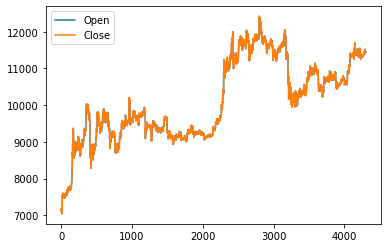

In [118]:

plt.plot(df["Open"])
plt.plot(df["Close"])
plt.legend(["Open","Close"])
plt.show()

In [119]:


#Generator Model
def make_generator_model():

    model = Sequential()
    model.add(tf.keras.layers.Reshape((in_size,1)))
    # model.add(Conv1D(filters=16*2, kernel_size=1,
    #         strides=3, padding="causal",
    #         activation="tanh"))
    # model.add(Conv1D(filters=16*2*2, kernel_size=1,
    #     strides=3, padding="causal",
    #     activation="tanh"))  
    # model.add(LSTM(units=10,return_sequences=True))    
    model.add(Flatten())
    model.add(Dense(256*2,activation='tanh'))
    model.add(Dense(256/2,activation='tanh'))
    # model.add(Dense(256,activation='sigmoid'))
    # model.add(Activation(custom_activation, name='SpecialActivation'))
    model.add(Dense(diviter*4, activation='linear'))
    model.add(Reshape((diviter,4)))
    # model.add(Activation(custom_activation, name='SpecialActivation'))
    return model

# Descriminator model


def make_discriminator_model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=1,strides=3, padding="causal", activation='relu', input_shape=[diviter,4]))
    model.add(Dropout(0.5))
    model.add(Conv1D(filters=64, kernel_size=1, strides=3, padding="causal",activation='relu'))
    model.add(Dropout(0.5))
    # model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='linear'))
    return model

In [120]:


#################################################################################
#          Prepare metrics for logging
#################################################################################

disc_losses = tf.keras.metrics.Mean('disc_loss', dtype=tf.float32)
disc_losses_list = []

### discriminator accuracy ###
fake_disc_accuracy = tf.keras.metrics.BinaryAccuracy('fake_disc_accuracy')
real_disc_accuracy = tf.keras.metrics.BinaryAccuracy('real_disc_accuracy')
fake_disc_accuracy_list, real_disc_accuracy_list = [], []

### generator loss ###
# gen_log_dir = 'logs/gradient_tape/gen_loss'
# gen_summary_writer = tf.summary.create_file_writer(gen_log_dir)
gen_losses = tf.keras.metrics.Mean('gen_loss', dtype=tf.float32)
gen_losses_list = []


#################################################################################
#          Prepare loss functions and optimizers
#################################################################################

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(0.002)
discriminator_optimizer = tf.keras.optimizers.Adam(0.002)


In [121]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [122]:
noise_dim = in_size
disc_steps = 1


@tf.function
def train_step(real):
    noise = A*tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as disc_tape:
        generated = generator(noise, training=True)

        real_output = discriminator(real, training=True)
        fake_output = discriminator(generated, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    ### for tensorboard ###
    disc_losses.update_state(disc_loss)
    fake_disc_accuracy.update_state(tf.zeros_like(fake_output), fake_output)
    real_disc_accuracy.update_state(tf.ones_like(real_output), real_output)
    #######################
    
    with tf.GradientTape() as gen_tape:
        generated = generator(noise, training=True)
        fake_output = discriminator(generated, training=True)

        gen_loss =1*generator_loss(fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    ### for tensorboard ###
    gen_losses.update_state(gen_loss)
    #######################


def train(dataset, epochs):
    for epoch in tqdm(range(epochs)):
    
        for batch in dataset:
            train_step(batch)
            
        disc_losses_list.append(disc_losses.result().numpy())
        gen_losses_list.append(gen_losses.result().numpy())
        
        fake_disc_accuracy_list.append(fake_disc_accuracy.result().numpy())
        real_disc_accuracy_list.append(real_disc_accuracy.result().numpy())
            
        disc_losses.reset_states()        
        gen_losses.reset_states()
        
        fake_disc_accuracy.reset_states()
        real_disc_accuracy.reset_states()
        

train(train_dataset, EPOCHS)


100%|██████████| 300/300 [00:10<00:00, 28.04it/s]


In [123]:
generator.save('gen.h5')
discriminator.save('disc.h5')

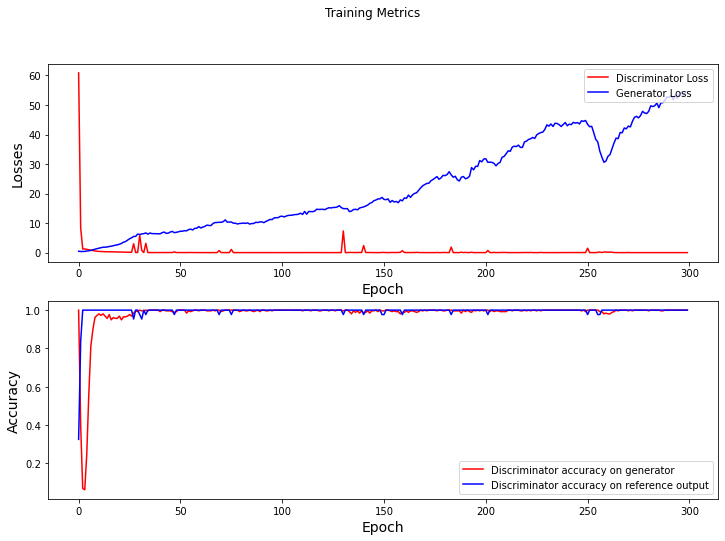

In [124]:
# %reload_ext tensorboard
# %tensorboard --logdir logs/gradient_tape

fig, axes = plt.subplots(2, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Losses", fontsize=14)
axes[0].set_xlabel("Epoch", fontsize=14)
axes[0].plot(disc_losses_list, color='red')
axes[0].plot(gen_losses_list, color='blue')
axes[0].legend(['Discriminator Loss', 'Generator Loss'], loc='upper right')

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(fake_disc_accuracy_list, color='red')
axes[1].plot(real_disc_accuracy_list, color='blue')
axes[1].legend(['Discriminator accuracy on generator', 'Discriminator accuracy on reference output'], loc='lower right')
plt.show()

In [125]:
L_algebra=43
seed=A*tf.random.normal([L_algebra,in_size])

X_p=generator.predict(seed)
X_p.shape

sig1_rec=[]
sig2_rec=[]

for i in range(L_algebra):
    x1=X_p[i,:,0]
    x2=X_p[i,:,1]
    x1p=X_p[i,:,2]
    x2p=X_p[i,:,3]

    fft_sig1=x1*np.exp(1j*x1p)
    fft_sig2=x2**np.exp(1j*x2p)

    sig1=np.real(np.fft.ifft(fft_sig1))
    sig2=np.real(np.fft.ifft(fft_sig2))

    sig1_rec.append(sig1)
    sig2_rec.append(sig2)



Sig1=np.asarray(sig1_rec).flatten()
Sig2=np.asarray(sig2_rec).flatten()



con1_2=Sig1*scaler
con2_2=Sig2*scaler


df2['Open'] =Sig1*scaler
df2['Close'] =Sig2*scaler



# save df2 as csv
df2.to_csv('price_data_replica.csv')
df2.head(15)

,Date,Open,High,Low,Close,Volume
0,2020-04-23 00:00,422.619974,7158.70,7108.00,829.289204,81.59
1,2020-04-23 01:00,361.337997,7192.82,7118.33,995.384111,175.45
2,2020-04-23 02:00,418.214447,7193.13,7129.19,460.734034,131.63
3,2020-04-23 03:00,441.567280,7163.41,7117.97,720.613745,227.12
4,2020-04-23 04:00,391.645810,7137.92,7102.62,509.359013,60.48
5,2020-04-23 05:00,282.646067,7142.48,7098.86,258.360154,90.99
6,2020-04-23 06:00,379.395747,7103.31,7031.07,298.125470,452.96
7,2020-04-23 07:00,352.099963,7081.85,7038.45,649.365121,87.46
8,2020-04-23 08:00,369.523901,7108.19,7055.00,851.923567,161.56
9,2020-04-23 09:00,427.867618,7111.38,7056.42,973.375011,203.53


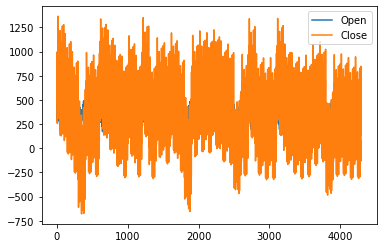

In [129]:
plt.plot(df2["Open"])
plt.plot(df2["Close"])
plt.legend(["Open","Close"])
plt.show()

In [127]:
C1=np.concatenate((con1_1,con1_2 ), axis=0)
C2=np.concatenate((con2_1,con2_2 ), axis=0)
daty=np.arange(len(C1))

dataset = pd.DataFrame({'Date':daty,'Open': C1, 'Close': C2})
df2.to_csv('new_data.csv')